In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from skimage.morphology import skeletonize
from skimage.util import invert
import random




In [6]:
url = 'https://selleys.com.sg/wp-content/uploads/2022/08/Wide-cracks.png'  # Replace with the actual image URL
response = requests.get(url)
img_arr = np.array(bytearray(response.content), dtype=np.uint8)


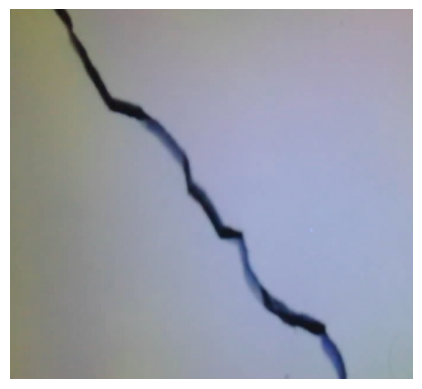

In [3]:
# img = cv2.imdecode(img_arr, -1)
img = cv2.imread('./sample/1.jpg')
plt.axis('off')
plt.imshow(img)



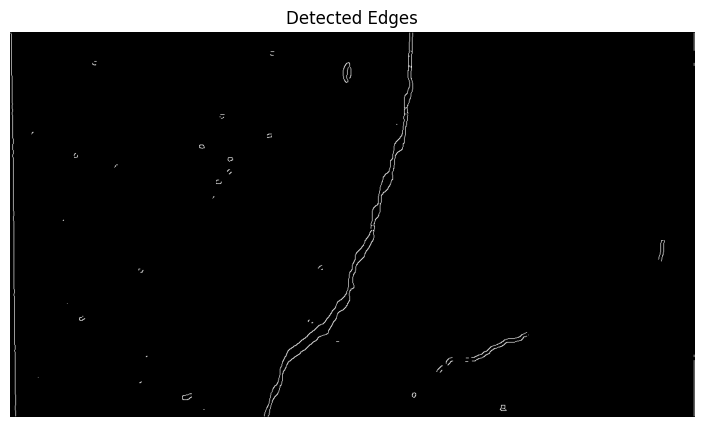

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, gaussian_filter
from skimage import io, color

def normalize(img):
    """Normalize the image to range [0, 1]."""
    return (img - img.min()) / (img.max() - img.min())

def sobel_filter(img, direction):
    """Apply Sobel filter in the given direction ('x' or 'y')."""
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)
    kernel = Gx if direction == 'x' else Gy
    
    if img.ndim == 3:  # If the image has 3 channels (e.g., RGB), process each separately
        filtered = np.zeros_like(img, dtype=np.float32)
        for i in range(img.shape[2]):
            filtered[..., i] = convolve(img[..., i], kernel)
        return filtered
    else:  # For grayscale images
        return convolve(img, kernel)

def non_maximum_suppression(magnitude, gradient):
    """Perform non-maximum suppression."""
    M, N = magnitude.shape
    nms = np.zeros((M, N), dtype=np.float32)
    angle = gradient * 180.0 / np.pi  # Convert to degrees
    angle[angle < 0] += 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            try:
                q = 255
                r = 255

                # Angle 0
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = magnitude[i, j + 1]
                    r = magnitude[i, j - 1]
                # Angle 45
                elif 22.5 <= angle[i, j] < 67.5:
                    q = magnitude[i + 1, j - 1]
                    r = magnitude[i - 1, j + 1]
                # Angle 90
                elif 67.5 <= angle[i, j] < 112.5:
                    q = magnitude[i + 1, j]
                    r = magnitude[i - 1, j]
                # Angle 135
                elif 112.5 <= angle[i, j] < 157.5:
                    q = magnitude[i - 1, j - 1]
                    r = magnitude[i + 1, j + 1]

                if magnitude[i, j] >= q and magnitude[i, j] >= r:
                    nms[i, j] = magnitude[i, j]
                else:
                    nms[i, j] = 0

            except IndexError as e:
                pass
    return nms

def crop_center(img, target_width, target_height):
    """Crop the image from the center to the target dimensions."""
    y, x = img.shape[:2]
    start_x = (x - target_width) // 2
    start_y = (y - target_height) // 2
    return img[start_y:start_y + target_height, start_x:start_x + target_width]

def edge_detection(img, target_width=500, target_height=500):
    """Complete edge detection pipeline with center cropping."""
    # Load and preprocess the image
    
    if img.ndim == 3:  # If RGB, convert to grayscale
        img = color.rgb2gray(img)
    img = normalize(img)

    # Crop the image from the center
    # img_cropped = crop_center(img, target_width, target_height)
    

    # Apply Gaussian smoothing
    img_smoothed = gaussian_filter(img, sigma=1)

    # Compute Sobel gradients
    Gx = sobel_filter(img_smoothed, 'x')
    Gy = sobel_filter(img_smoothed, 'y')

    # Compute gradient magnitude and direction
    magnitude = np.sqrt(Gx**2 + Gy**2)
    magnitude = normalize(magnitude)  # Normalize the gradient magnitude
    gradient = np.arctan2(Gy, Gx)

    # Apply Non-Maximum Suppression
    nms = non_maximum_suppression(magnitude, gradient)

    # Apply thresholding
    threshold = 0.2  # Adjust as needed
    edges = np.zeros_like(nms)
    edges[nms >= threshold] = 1
    return edges

# Input image path
image_path = './sample/3.jpg'  # Replace with your image path
img = cv2.imread(image_path)
edges = edge_detection(img)

med_val = np.median(img)
lower = int(max(0, 0.7 * med_val))
upper = int(min(255, 1.3 * med_val))
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges1 = cv2.Canny(image=img, threshold1=lower, threshold2=upper + 50)




# Display results
plt.figure(figsize=(10, 5))
plt.imshow(edges, cmap='gray')
plt.title("Detected Edges")
plt.axis('off')
plt.show()

In [19]:
import cv2
import numpy as np
import random
from skimage.morphology import skeletonize
def crack_detection(img):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a blur to the grayscale image
    blurred_img = cv2.GaussianBlur(gray_image, (3, 3), 0)

    # Thresholding to get a binary image (inverse binary to highlight cracks)
    _, binary_img = cv2.threshold(blurred_img, 127, 255, cv2.THRESH_BINARY_INV)

    # Skeletonize the inverted binary image to get a thin representation of the cracks
    skeleton = skeletonize(binary_img // 255).astype(np.uint8) * 255  # Convert boolean to uint8 for OpenCV

    # Detect edges using a custom edge detection function (replace `edge_detection` with your implementation)
    edges = edge_detection(img)

    # Create a list of edge points for distance calculation
    edge_points = np.column_stack(np.where(edges > 0))

    if len(edge_points) == 0:
        return img, []  # If no edges are detected, return the original image and an empty list

    # Get the coordinates of the skeleton points
    skeleton_points = np.column_stack(np.where(skeleton > 0))

    if len(skeleton_points) == 0:
        return img, []  # If no skeleton points are detected, return original image and an empty list

    # Filter skeleton points to keep only those within a 30-pixel range of the edges
    filtered_skeleton_points = []
    threshold_distance = 10

    for sp in skeleton_points:
        distances = np.sqrt(np.sum((edge_points - sp) ** 2, axis=1))
        if np.any(distances <= threshold_distance):
            filtered_skeleton_points.append(sp)

    filtered_skeleton_points = np.array(filtered_skeleton_points)

    # If no skeleton points remain after filtering, return the original image
    if len(filtered_skeleton_points) == 0:
        return img, []

    # Set the number of perpendicular lines to visualize
    num_perpendicular_lines = 20
    perpendicular_distances = []  # To store the distances of intersections

    # Draw detected edges in red color on the original image
    img_with_edges = img.copy()
    img_with_edges[edges > 0] = [0, 0, 255]  # Red color for edges

    # Iterate to add perpendicular lines
    for _ in range(num_perpendicular_lines):
        # Randomly select a point on the filtered skeleton
        random_point = filtered_skeleton_points[random.randint(0, len(filtered_skeleton_points) - 1)]

        # Get the neighbors for directional vector (choosing nearby points)
        index = np.where((filtered_skeleton_points[:, 0] == random_point[0]) & (filtered_skeleton_points[:, 1] == random_point[1]))[0][0]
        prev_point = filtered_skeleton_points[index - 1] if index > 0 else random_point
        next_point = filtered_skeleton_points[index + 1] if index < len(filtered_skeleton_points) - 1 else random_point

        # Calculate the direction vector and perpendicular vector
        direction_vector = (next_point[0] - prev_point[0], next_point[1] - prev_point[1])
        perpendicular_vector = (-direction_vector[1], direction_vector[0])

        # Normalize the perpendicular vector
        length = np.sqrt(perpendicular_vector[0] ** 2 + perpendicular_vector[1] ** 2)
        if length == 0:  # Avoid division by zero
            continue
        perpendicular_vector = (perpendicular_vector[0] / length, perpendicular_vector[1] / length)

        # Define the length of the perpendicular line
        perpendicular_length = 30

        # Calculate the start and end points of the perpendicular line
        start_perpendicular = (int(random_point[0] - perpendicular_length * perpendicular_vector[0]),
                               int(random_point[1] - perpendicular_length * perpendicular_vector[1]))

        end_perpendicular = (int(random_point[0] + perpendicular_length * perpendicular_vector[0]),
                             int(random_point[1] + perpendicular_length * perpendicular_vector[1]))

        # Draw the perpendicular line on the image with edges
        cv2.line(img_with_edges, (start_perpendicular[1], start_perpendicular[0]),
                 (end_perpendicular[1], end_perpendicular[0]), (0, 255, 0), 2)

        # Detect intersections of the perpendicular line with edges
        intersections = []
        rr, cc = np.linspace(start_perpendicular[0], end_perpendicular[0], num=100).astype(int), \
                 np.linspace(start_perpendicular[1], end_perpendicular[1], num=100).astype(int)

        for r, c in zip(rr, cc):
            if 0 <= r < edges.shape[0] and 0 <= c < edges.shape[1]:
                if edges[r, c] > 0:  # Check if the pixel is part of the edge
                    intersections.append((r, c))

        # If there are intersections, plot them and calculate distance
        if len(intersections) >= 2:
            first_intersection = intersections[0]
            last_intersection = intersections[-1]

            # Plot intersection points
            cv2.circle(img_with_edges, (first_intersection[1], first_intersection[0]), 3, (255, 0, 0), -1)
            cv2.circle(img_with_edges, (last_intersection[1], last_intersection[0]), 3, (255, 0, 0), -1)

            # Calculate the distance between intersections
            distance = np.sqrt((last_intersection[0] - first_intersection[0]) ** 2 +
                               (last_intersection[1] - first_intersection[1]) ** 2)
            if distance > 0:
                perpendicular_distances.append(round(distance, 3))

    # Return the modified image and the calculated distances (for further use)
    return img_with_edges, perpendicular_distances

Perpendicular Distances (in pixels): [11.18, 21.471, 16.553, 12.728, 18.385, 12.728, 15.652, 12.53, 21.213, 18.788, 21.19, 18.0, 17.0, 18.385, 19.799, 14.765, 10.0, 1.0]


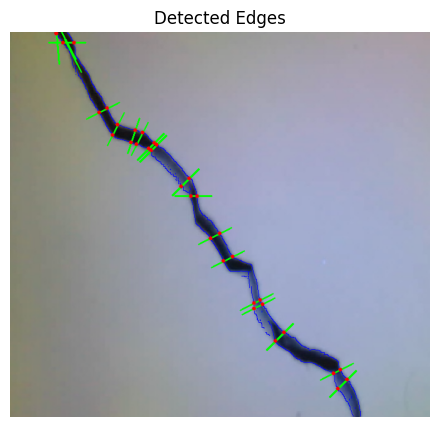

In [32]:
image_path = './sample/1.jpg'  # Replace with your image path
img1 = cv2.imread(image_path)

img_with_edges, perpendicular_distances = crack_detection(img1)
print("Perpendicular Distances (in pixels):", perpendicular_distances)

plt.figure(figsize=(10, 5))
plt.imshow(img_with_edges, cmap='gray')
plt.title("Detected Edges")
plt.axis('off')
plt.show()

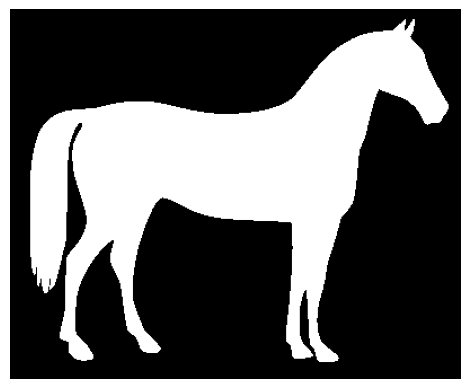

In [25]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

# Invert the horse image
image = invert(data.horse())

# perform skeletonization
skeleton = skeletonize(image)



plt.imshow(image, cmap=plt.cm.gray)
plt.axis('off')

plt.show()

In [26]:

# Convert the image to grayscale
gray_image1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Use cv2.cvtColor instead of cv2.colorChange

bl2 = cv2.blur(gray_image1, ksize=(3,3))


res , bl = cv2.threshold( bl2 , 127, 255, 0)

bl = invert(bl)

skeleton = skeletonize(bl//255)
plt.imshow(skeleton, cmap='gray')

error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


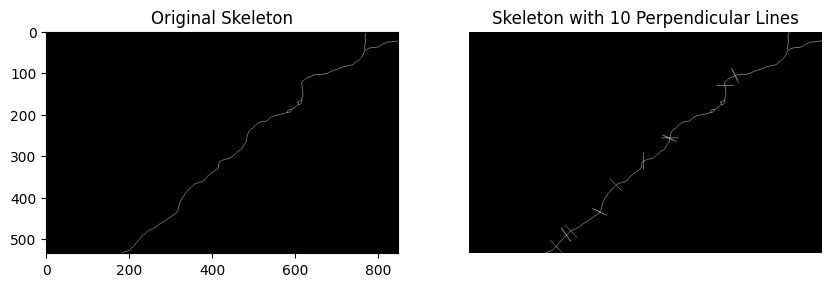

In [6]:


# Get the coordinates of the skeleton points
skeleton_points = np.column_stack(np.where(skeleton > 0))

# Set the number of perpendicular lines
num_perpendicular_lines = 10

# Create a copy of the skeleton to draw the perpendicular lines
skeleton_with_perpendicular = np.zeros_like(skeleton)  # Create a black image with the same shape as the skeleton
skeleton_with_perpendicular[skeleton > 0] = 1  # Keep the skeleton in the new image

for _ in range(num_perpendicular_lines):
    # Randomly select a point on the skeleton
    random_point = skeleton_points[random.randint(0, len(skeleton_points) - 1)]

    # Calculate the perpendicular line coordinates
    index = np.where((skeleton_points[:, 0] == random_point[0]) & (skeleton_points[:, 1] == random_point[1]))[0][0]
    prev_point = skeleton_points[index - 1] if index > 0 else random_point
    next_point = skeleton_points[index + 1] if index < len(skeleton_points) - 1 else random_point

    # Calculate the direction vector of the line segment
    direction_vector = (next_point[0] - prev_point[0], next_point[1] - prev_point[1])

    # Calculate the perpendicular vector (rotated 90 degrees)
    perpendicular_vector = (-direction_vector[1], direction_vector[0])

    # Normalize the perpendicular vector
    length = np.sqrt(perpendicular_vector[0]**2 + perpendicular_vector[1]**2)
    perpendicular_vector = (perpendicular_vector[0] / length, perpendicular_vector[1] / length)

    # Define the length of the perpendicular line
    perpendicular_length = 20

    # Calculate the endpoints of the perpendicular line
    start_perpendicular = (int(random_point[0] - perpendicular_length * perpendicular_vector[0]),
                           int(random_point[1] - perpendicular_length * perpendicular_vector[1]))

    end_perpendicular = (int(random_point[0] + perpendicular_length * perpendicular_vector[0]),
                        int(random_point[1] + perpendicular_length * perpendicular_vector[1]))

    # Draw the perpendicular line on the skeleton copy
    rr, cc = np.linspace(start_perpendicular[0], end_perpendicular[0], num=100).astype(int), \
             np.linspace(start_perpendicular[1], end_perpendicular[1], num=100).astype(int)

    for r, c in zip(rr, cc):
        if 0 <= r < skeleton_with_perpendicular.shape[0] and 0 <= c < skeleton_with_perpendicular.shape[1]:
            skeleton_with_perpendicular[r, c] = 1  # Draw the perpendicular line

# Display the skeleton and the image with the perpendicular lines
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(skeleton, cmap='gray')
plt.title('Original Skeleton')

plt.subplot(1, 2, 2)
plt.imshow(skeleton_with_perpendicular, cmap='gray')
plt.title(f'Skeleton with {num_perpendicular_lines} Perpendicular Lines')
plt.axis('off')  # Turn off axis labels
plt.show()

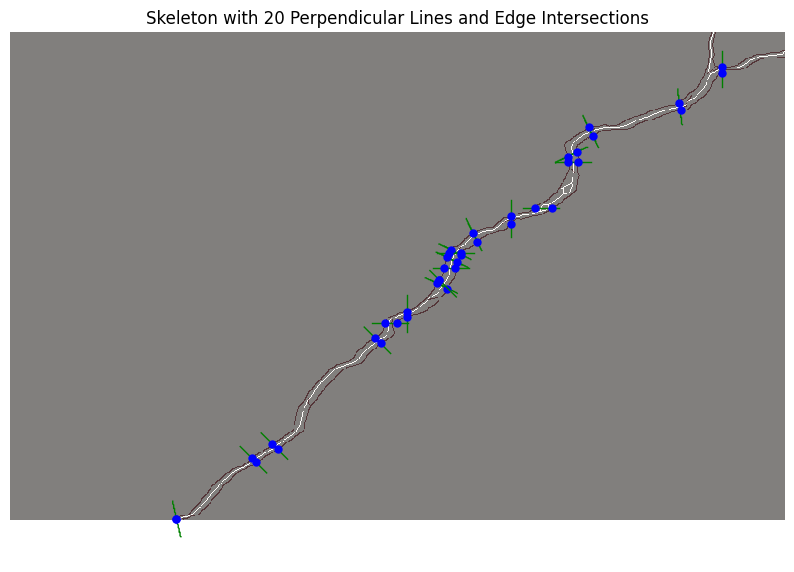

Distances where perpendicular lines cross edges (in pixels):
[8.48528137423857, 1.0, 12.529964086141668, 8.246211251235321, 13.0, 12.529964086141668, 8.48528137423857, 11.180339887498949, 12.529964086141668, 6.0, 19.0, 12.0, 10.0, 0.0, 9.0, 10.295630140987, 10.295630140987, 6.0, 5.656854249492381, 13.0]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming 'skeleton' is the binary skeleton image and 'edges' is the binary edge image

# Set the number of perpendicular lines
num_perpendicular_lines = 20

# Get the coordinates of the skeleton points
skeleton_points = np.column_stack(np.where(skeleton > 0))

# Create a figure to visualize everything
plt.figure(figsize=(10, 10))

# Plot the skeleton in white
plt.imshow(skeleton, cmap='gray', interpolation='none', alpha=0.7)

# Overlay the edges in red
plt.imshow(edges, cmap='Reds', interpolation='none', alpha=0.3)

perpendicular_distances = []  # To store the distances for each perpendicular line

for _ in range(num_perpendicular_lines):
    # Randomly select a point on the skeleton (same as before)
    random_point = skeleton_points[random.randint(0, len(skeleton_points) - 1)]
    index = np.where((skeleton_points[:, 0] == random_point[0]) & (skeleton_points[:, 1] == random_point[1]))[0][0]
    prev_point = skeleton_points[index - 1] if index > 0 else random_point
    next_point = skeleton_points[index + 1] if index < len(skeleton_points) - 1 else random_point

    # Calculate the direction vector and the perpendicular vector (same as before)
    direction_vector = (next_point[0] - prev_point[0], next_point[1] - prev_point[1])
    perpendicular_vector = (-direction_vector[1], direction_vector[0])

    # Normalize the perpendicular vector (same as before)
    length = np.sqrt(perpendicular_vector[0]**2 + perpendicular_vector[1]**2)
    perpendicular_vector = (perpendicular_vector[0] / length, perpendicular_vector[1] / length)

    # Define the length of the perpendicular line (same as before)
    perpendicular_length = 20

    # Calculate the endpoints of the perpendicular line (same as before)
    start_perpendicular = (int(random_point[0] - perpendicular_length * perpendicular_vector[0]),
                           int(random_point[1] - perpendicular_length * perpendicular_vector[1]))

    end_perpendicular = (int(random_point[0] + perpendicular_length * perpendicular_vector[0]),
                         int(random_point[1] + perpendicular_length * perpendicular_vector[1]))

    # Get the coordinates of the perpendicular line
    rr, cc = np.linspace(start_perpendicular[0], end_perpendicular[0], num=100).astype(int), \
             np.linspace(start_perpendicular[1], end_perpendicular[1], num=100).astype(int)

    # Find where this line intersects with the edges image
    intersections = []
    for r, c in zip(rr, cc):
        if 0 <= r < edges.shape[0] and 0 <= c < edges.shape[1]:
            if edges[r, c] > 0:  # Check if the pixel belongs to an edge
                intersections.append((r, c))

    # Draw the perpendicular line in green
    plt.plot(cc, rr, color='green', linewidth=1)

    # If there are intersections, mark them and calculate the distance
    if len(intersections) >= 2:
        first_intersection = intersections[0]
        last_intersection = intersections[-1]
        
        # Plot intersection points
        plt.plot([first_intersection[1], last_intersection[1]], [first_intersection[0], last_intersection[0]],
                 'bo', markersize=5)  # Mark intersections with blue circles
        
        # Compute the distance between the first and last intersection in pixels
        distance = np.sqrt((last_intersection[0] - first_intersection[0])**2 + 
                           (last_intersection[1] - first_intersection[1])**2)
        perpendicular_distances.append(distance)
    else:
        # No intersections found, set distance to 0 for this perpendicular line
        perpendicular_distances.append(0)

# Title and axis adjustments
plt.title(f'Skeleton with {num_perpendicular_lines} Perpendicular Lines and Edge Intersections')
plt.axis('off')  # Turn off axis labels
plt.show()

# Print or process the distances for each perpendicular line
print("Distances where perpendicular lines cross edges (in pixels):")
print(perpendicular_distances)

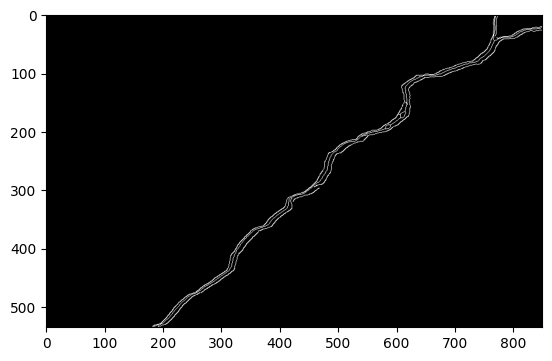

In [9]:
full = skeleton + edges

new_img = np.zeros(skeleton.shape, dtype=np.uint8)
new_img = np.where((skeleton > 0) | (edges > 0), 255, 0).astype(np.uint8)


plt.imshow(new_img, cmap='gray')


In [ ]:
#draw a perpendicular line for the skeleton
for i in range(new_img.shape[0]):
    for j in range(new_img.shape[1]):
        if skeleton[i][j] > 0:
            i1 = i
            j1 = j
            if edges[i][j+1] > 0:
                i2 = i
                j2 = j+1
                break


Widths: [2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 2, 2, 2, 2, 4, 3, 3, 3, 2, 2, 2, 2, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 2, 2, 3, 4, 3, 3, 3, 3, 2, 3, 3, 3, 4, 2, 2, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 2, 2, 4, 3, 3, 3, 2, 3, 3, 3, 3, 4, 3, 2, 2, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 4, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3, 4, 2, 3, 3, 3, 3, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3, 3, 3, 2, 4, 3, 2, 2, 2, 3, 3, 2, 3, 3, 2, 4, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 4, 3, 3, 2, 3, 3, 4, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 3, 4, 3, 3, 2, 3, 3, 4, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 4, 2, 3, 3, 3, 2, 3, 2, 3

/var/folders/gh/ct0p90656djfbz1pmtmn05_r0000gn/T/ipykernel_67275/1121031455.py:45: RuntimeWarning: invalid value encountered in divide
  perp_vector = perp_vector / np.linalg.norm(perp_vector)  # Normalize
/var/folders/gh/ct0p90656djfbz1pmtmn05_r0000gn/T/ipykernel_67275/1121031455.py:55: RuntimeWarning: invalid value encountered in cast
  new_point = new_point.astype(int)


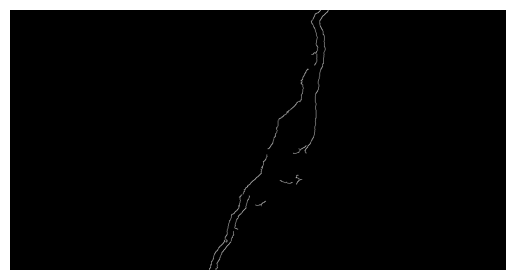

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

# turn into grayscale

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Median calculation for adaptive Canny thresholds
med_val = np.median(img)
lower = int(max(0, 0.7 * med_val))
upper = int(min(255, 1.3 * med_val))

# Apply blur to reduce noise
blurred_img = cv2.blur(img, ksize=(5, 5))

# Edge detection using Canny
edges = cv2.Canny(image=blurred_img, threshold1=lower, threshold2=upper + 50)

# Threshold to get binary image
_, edges = cv2.threshold(edges, 127, 255, 0)

# Skeletonize the edges to thin them down to a single-pixel width crack
skeleton = skeletonize(edges // 255).astype(np.uint8)

# Find contours of the crack skeleton
contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Function to calculate the perpendicular direction and width
def calculate_perpendicular_width(contour, edges):
    width_list = []
    
    for i in range(1, len(contour) - 1):
        # Get the current, previous, and next points
        p1 = contour[i - 1][0]
        p2 = contour[i][0]
        p3 = contour[i + 1][0]
        
        # Estimate the tangent (approximate local direction of the crack)
        tangent_vector = np.array([p3[0] - p1[0], p3[1] - p1[1]])
        
        # Perpendicular vector (rotate tangent by 90 degrees)
        perp_vector = np.array([-tangent_vector[1], tangent_vector[0]])
        perp_vector = perp_vector / np.linalg.norm(perp_vector)  # Normalize

        # Measure crack width by following the perpendicular direction
        length = 0
        max_length = 0
        for sign in [-1, 1]:  # Search in both directions (positive and negative)
            step = 0
            while True:
                # Calculate the new point along the perpendicular direction
                new_point = np.array(p2) + step * sign * perp_vector
                new_point = new_point.astype(int)
                
                # Check if the point is inside the image and part of the crack
                if (0 <= new_point[1] < edges.shape[0]) and (0 <= new_point[0] < edges.shape[1]):
                    if edges[new_point[1], new_point[0]] > 0:
                        length += 1
                    else:
                        break
                else:
                    break
                step += 1
            max_length = max(max_length, length)
        
        if max_length > 0:
            width_list.append(max_length)

    return width_list

# Iterate over all contours and measure crack width
widths = []
for contour in contours:
    widths += calculate_perpendicular_width(contour, edges)

# Convert widths to a numpy array
width_array = np.array(widths)

# Print the results
print("Widths:", widths)
print("Max width:", np.max(width_array))
print("Mean width:", np.mean(width_array))

# Plot the edges
plt.axis('off')
plt.imshow(edges, cmap='gray')
plt.show()